In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import csv

%matplotlib inline
plt.rcParams['axes.linewidth'] = 2

Reading the data here. The Kaggle page does not provide documentation, so cleaning will require some guessing and assumptions. 

In [3]:
df = pd.read_csv("data/us_perm_visas.csv", 
                 low_memory=False, 
                 parse_dates=True,
                 delimiter=',',
                 true_values=["Y"],
                 false_values=["N"])
print(df.shape)

(374362, 154)


First, check the state of the outcome variable.

In [4]:
df.case_status.value_counts(dropna=False)

Certified            181933
Certified-Expired    148586
Denied                25649
Withdrawn             18194
Name: case_status, dtype: int64

In [5]:
classifier = (df['case_status'] == 'Certified') | (df['case_status'] == 'Denied')
df = df[classifier]
df.case_status.value_counts(dropna=False)

Certified    181933
Denied        25649
Name: case_status, dtype: int64

In [6]:
# remove small # (<50) cases where wage not entered annually
yearly = df['pw_unit_of_pay_9089']== 'Year'
df = df[yearly]

#combine two columns for citizenship.
df['country_of_citizenship'] = df.country_of_citizenship.fillna('')
df['country_of_citzenship'] = df.country_of_citzenship.fillna('')
citizenship = df['country_of_citizenship'] + df['country_of_citzenship']
df['citizenship'] = citizenship

#combine two columns for job title
df['add_these_pw_job_title_9089'] = df.add_these_pw_job_title_9089.fillna('')
df['pw_job_title_9089'] = df.pw_job_title_9089.fillna('')
job_title = df['pw_job_title_9089'] + df['add_these_pw_job_title_9089']
df['job_title'] = job_title

#drop excess columns
df = df.drop(['country_of_citizenship', 'country_of_citzenship', 'add_these_pw_job_title_9089', 'pw_job_title_9089'], axis = 1)

#select h_1b work visa applications
h_1b = df['class_of_admission']=='H-1B'
df = df[h_1b]

#convert pay to numeric
df['pw_amount_9089'] = df['pw_amount_9089'].str.replace(',','')
df['pw_amount_9089'] = pd.to_numeric(df['pw_amount_9089'])

### missing values

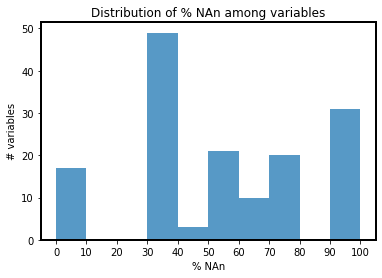

In [8]:
pct_na = (df.drop('case_status', 1).isna().sum() /df.shape[0]) * 100

counts, bins, patches = plt.hist(pct_na, 10, alpha = 0.75)

plt.xticks(np.arange(0, 101, 10))
plt.title('Distribution of % NAn among variables')
plt.xlabel('% NAn')
plt.ylabel('# variables')
plt.show()

Lots of variables missing observations. Check for patterns:

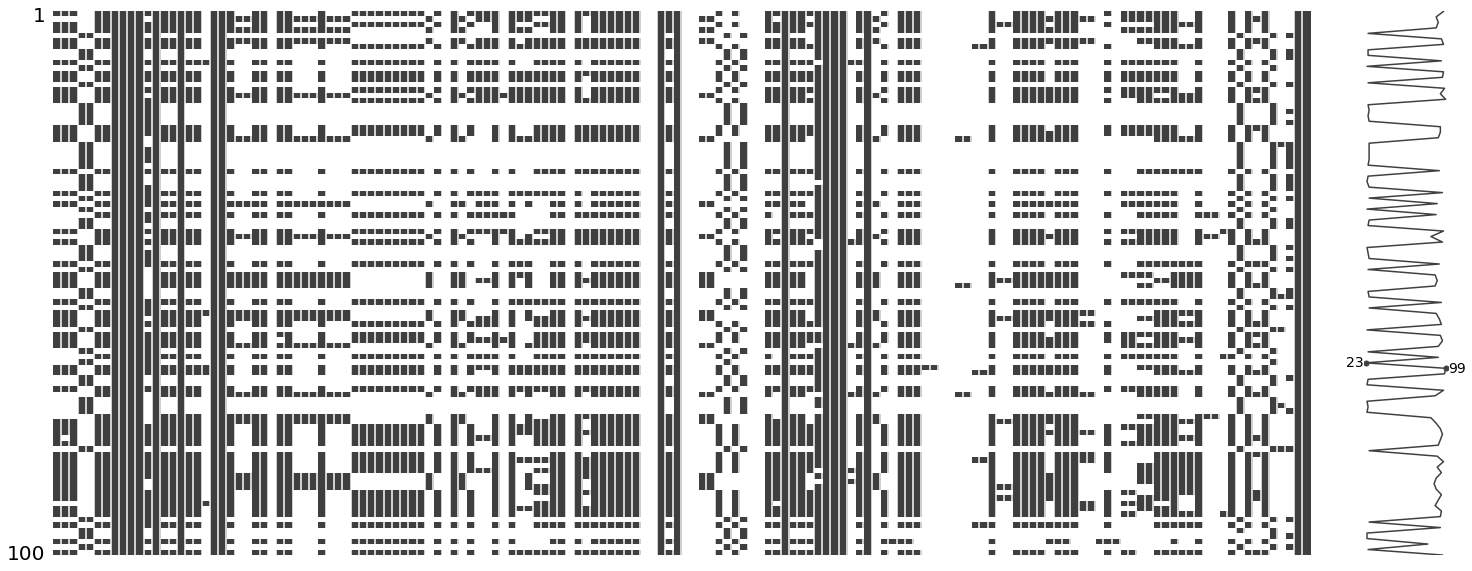

In [9]:
msno.matrix(df.sample(100))
plt.show()

Looks like a pattern. Sort rows by missingness:

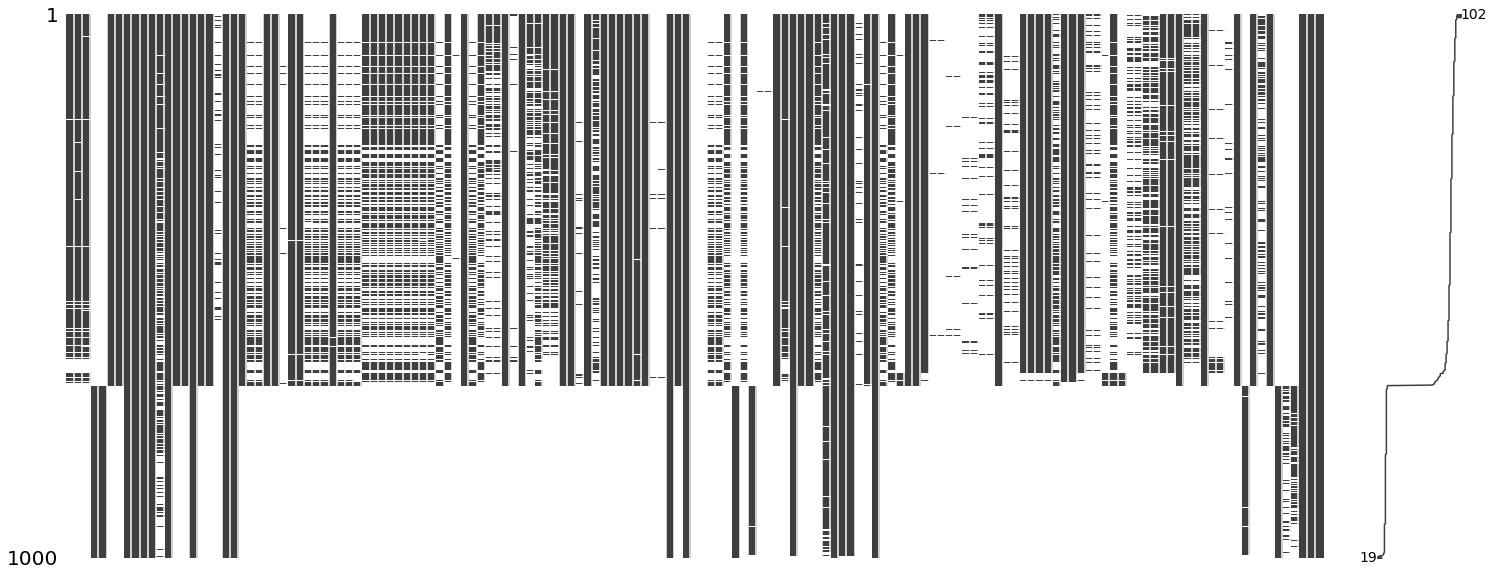

In [10]:
df_sample = df.sample(1000)
df_sample['null_count'] = df_sample.isnull().sum(axis=1)
df_sample = df_sample.sort_values(by = 'null_count')

msno.matrix(df_sample)
plt.show()

Section of obs missing most data. Zoom in to figure out why: 

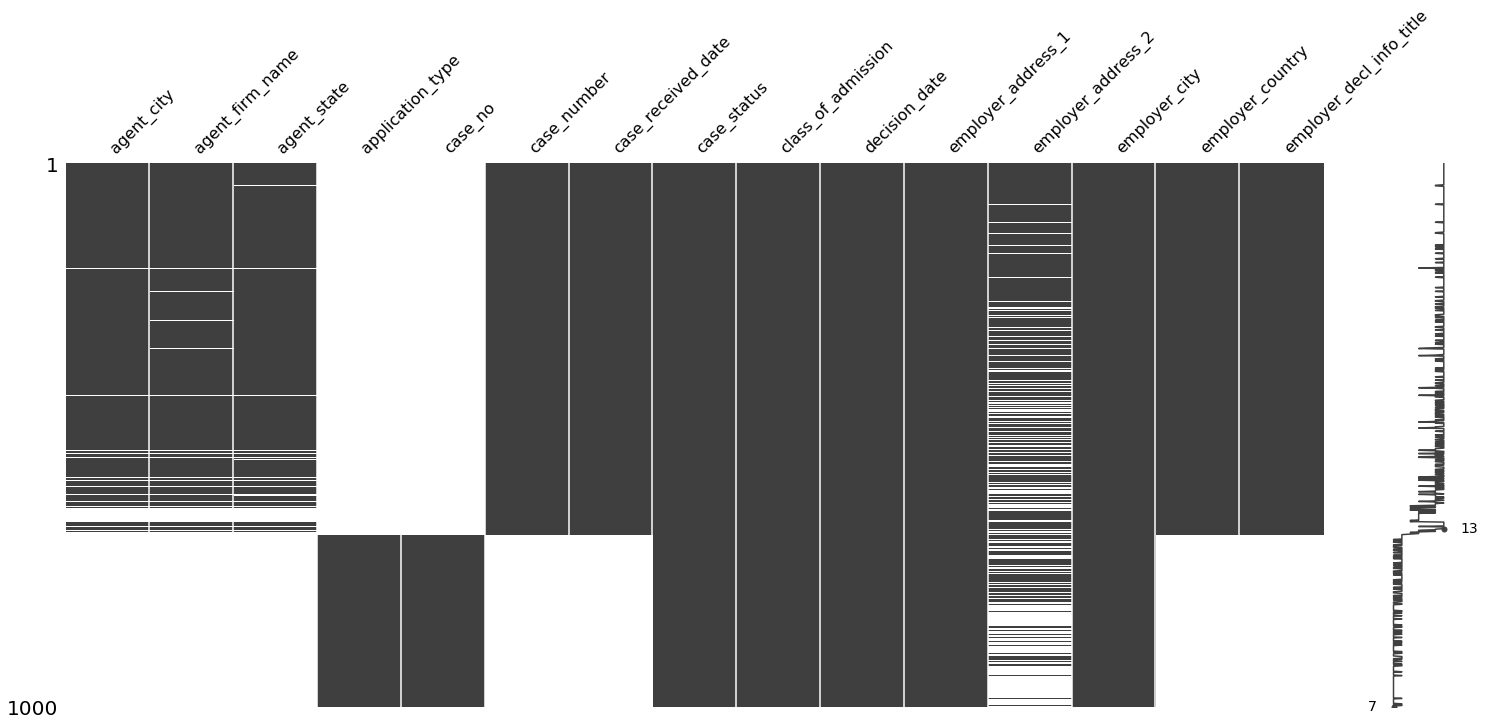

In [11]:
msno.matrix(df_sample.iloc[ : , 0:15])
plt.show()

Looks like the observations split into two groups. The first group has agents listed, while the second has an application type. I'll check the options for application type to look for hints about the logistics behind this distinction. 

In [12]:
df['application_type'].value_counts()

ONLINE      45877
MAILEDIN      365
Name: application_type, dtype: int64

Seems like these applicants may have done apps without an agent. 

TODO: Compare agent, non-agent applications. 

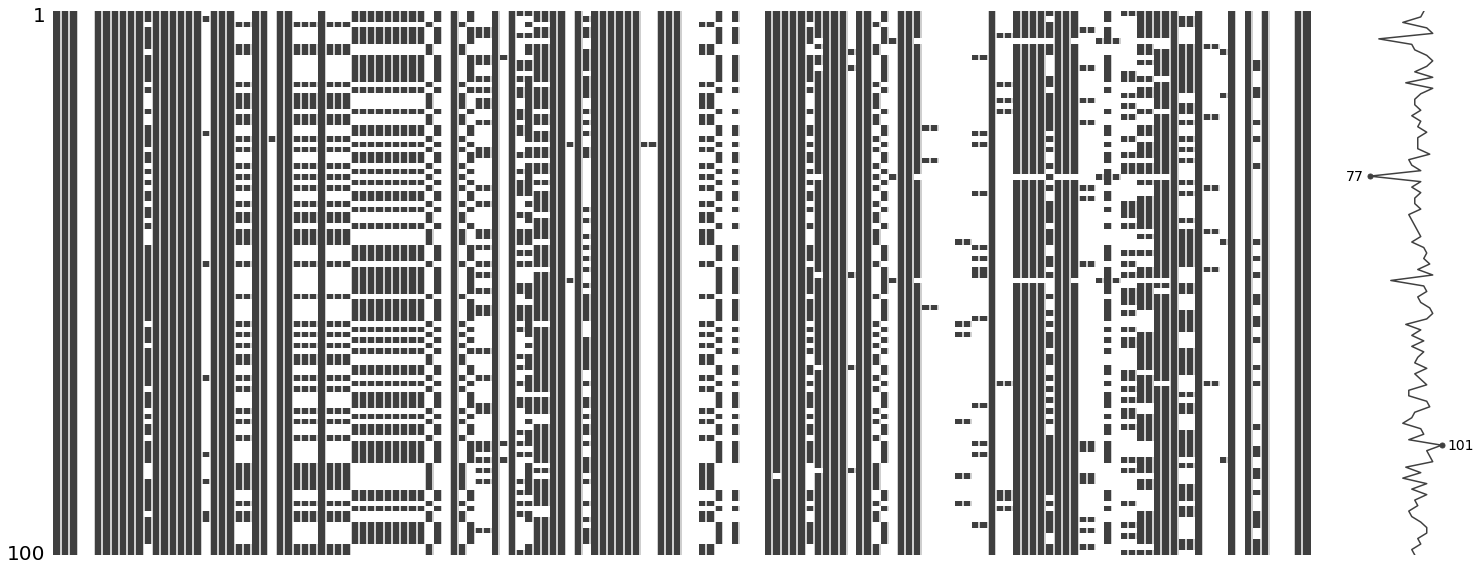

In [13]:
#cleaning out obs without agents

agent = pd.notnull(df['agent_firm_name']) | pd.notnull(df['agent_city']) | pd.notnull(df['agent_state'])
df = df[agent]

msno.matrix(df.sample(100))
plt.show()

Isolating applications made through agents makes the data look less sparse. Next, I'll get rid of empty columns.

(84399, 114)


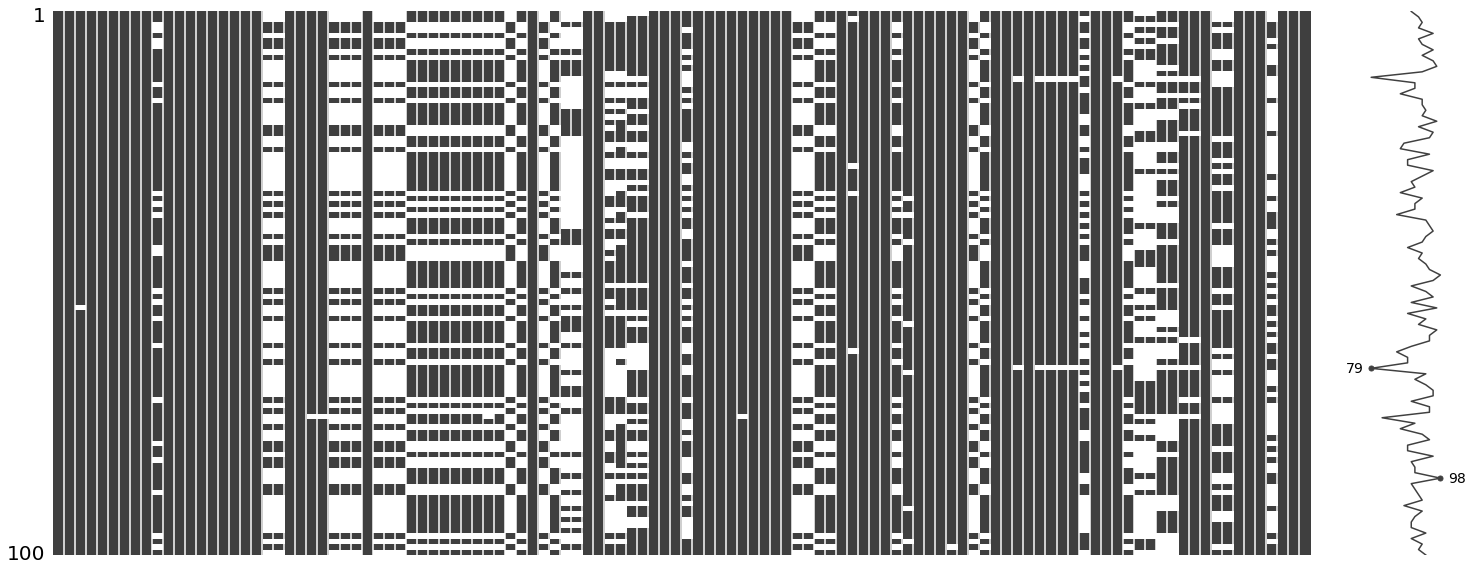

In [14]:
df = df[df.columns[df.isnull().mean() < 0.8]]
print(df.shape)

msno.matrix(df.sample(100))
plt.show()

Now looking quite good. Just on the left of the above matrix, it looks like there are still some patterns emerging. I looked at the columns in this region and found that variables containing information about the applicant's background had been split into two sets with different variable names. I could not easily identify what differentiated the two groups. One group was missing some variables, like education. So I decided to filter it out and look only at the other set.

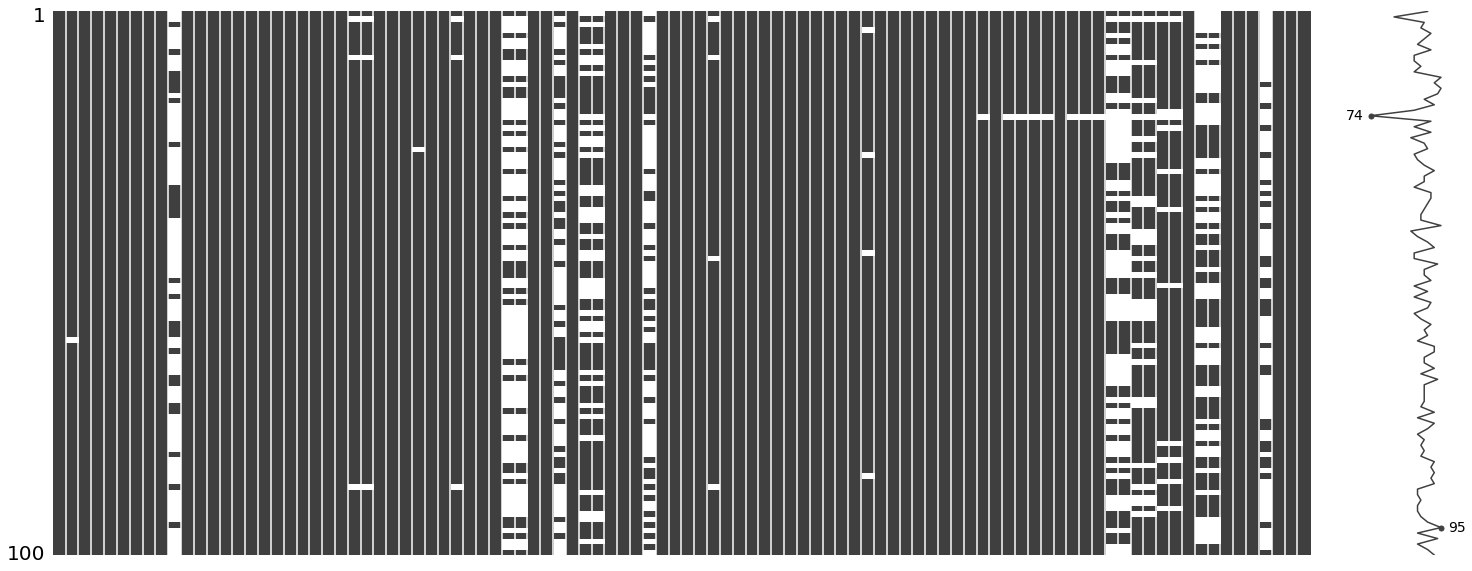

(29278, 98)


In [15]:
foreign_worker = pd.notnull(df['foreign_worker_info_alt_edu_experience'])
df = df[foreign_worker]
df = df[df.columns[df.isnull().mean() < 0.8]]
msno.matrix(df.sample(100))
plt.show()
print(df.shape)

I looked through these columns and cut down to only those I can unders

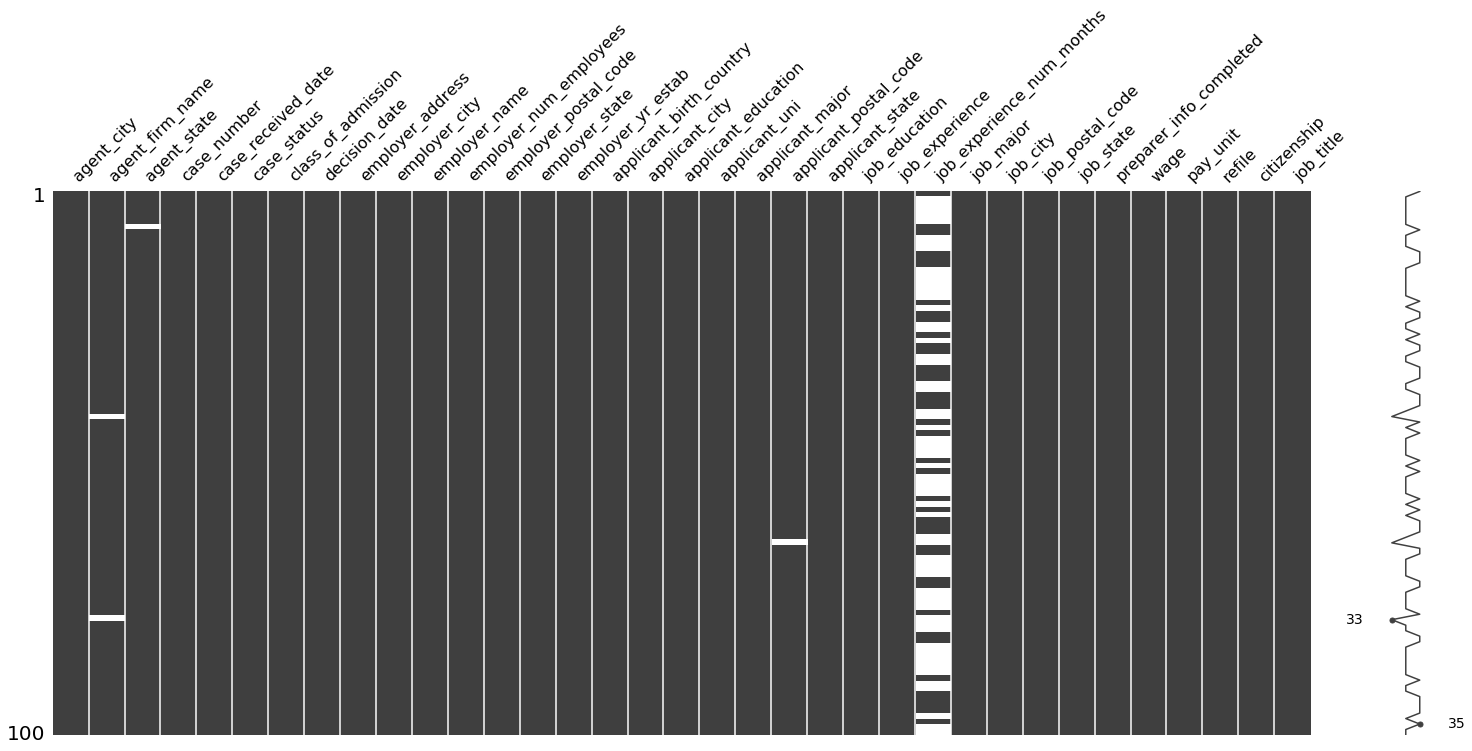

In [31]:
to_keep = pd.read_csv("lookups/to_keep.csv")
df = df.loc[:,to_keep['var_name']]
df.columns = to_keep['new_name']
msno.matrix(df.sample(100))
plt.show()

In [16]:
df.set_index('case_number')
df.to_csv(r'data\data_cleaned.csv')